# Audio Unit Selection Model - 01 Identify Musical Structure

In [7]:
import os
import warnings
import pickle as pkl
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt

import librosa

import torch
from sklearn.metrics.pairwise import cosine_similarity

from tqdm.auto import tqdm
from IPython.display import Audio

from feature_extractor import feature_extractor, feature_extractor_from_file

In [2]:
plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('computing on', device)

computing on cuda


In [4]:
MUSIC = '/home/arran/Music/Collection/Northworks/Northworks EP/Northworks - Northworks EP - 03 Through.mp3'

In [5]:
y, sr = librosa.load(MUSIC, None)

/home/arran/.pyenv/versions/3.7.3/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [6]:
tempo, beats = librosa.beat.beat_track(y, sr, units='samples')

In [7]:
print(f'{tempo:.2f}')

97.51


In [8]:
measure = y[beats[20]:beats[24]]

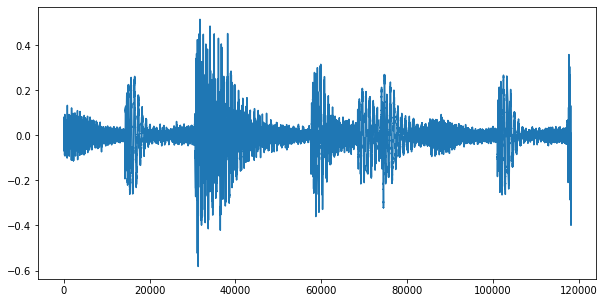

In [9]:
plt.plot(measure)

In [10]:
Audio(np.tile(measure, 4), rate=sr)

In [11]:
embedding_parameters = torch.load(f'models/AE_embedding_model.pt')

In [12]:
from models import LinearAE

In [13]:
model = LinearAE(**embedding_parameters['model_params']).to(device)

In [14]:
features = feature_extractor(measure, sr)

In [15]:
model.encode(torch.tensor(features['features'], dtype=torch.float))

tensor([-0.0713,  0.2481,  0.3560,  0.0614,  0.1332,  0.1257,  0.1884, -0.1857,
        -0.0035,  0.0228, -0.0289, -0.3605,  0.1495,  0.2376,  0.1525,  0.0905],
       grad_fn=<AddBackward0>)

In [16]:
measures = []
for i in range(int(len(beats) / 4) - 1):
    m_start = beats[i * 4]
    m_end = beats[i * 4 + 4]
    
    measures.append(y[m_start:m_end])

n_measures = len(measures)
print(f'found {n_measures} measures')

found 239 measures


In [17]:
measure_features = []
for m in tqdm(measures):
    measure_features.append(feature_extractor(m, sr))

measure_features = torch.stack([torch.tensor(mf['features'], dtype=torch.float) for mf in measure_features])

  0%|          | 0/239 [00:00<?, ?it/s]

In [18]:
encoded = model.encode(measure_features).detach().numpy()

In [19]:
ss = cosine_similarity(encoded)

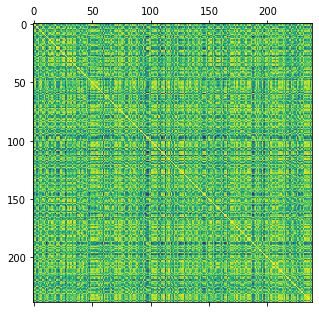

In [20]:
plt.matshow(ss)
plt.show()

In [21]:
m = measures[50]

In [22]:
unit_starts = librosa.onset.onset_detect(m, sr=sr, backtrack=True, units='samples')

In [23]:
units = []
for i in range(len(unit_starts) - 1):
    units.append(m[unit_starts[i]:unit_starts[i+1]])

In [24]:
from IPython.display import display

In [25]:
for u in units:
    display(Audio(u, rate=sr))

In [26]:
unit_features = [torch.tensor(feature_extractor(u, sr)['features'], dtype=torch.float) for u in units]

In [27]:
units_encoded = model.encode(torch.stack(unit_features))

In [28]:
with open('models/reducer.pkl', 'rb') as f:
    reducer = pkl.load(f)

In [29]:
units_reduced = reducer.transform(units_encoded.detach().numpy())

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


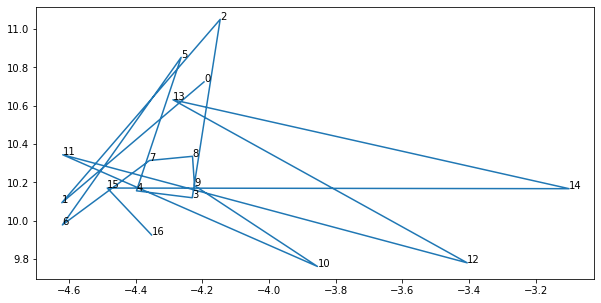

In [30]:
plt.plot(units_reduced[:, 0], units_reduced[:, 1])
for i, pos in enumerate(units_reduced):
    plt.text(pos[0], pos[1], i)
# plt.xlim(-8, 4)
# plt.ylim(4, 10)
plt.show()

In [31]:
units_reduced

array([[-4.195181 , 10.724704 ],
       [-4.6217213, 10.0941105],
       [-4.1466637, 11.051114 ],
       [-4.230502 , 10.120194 ],
       [-4.397762 , 10.156366 ],
       [-4.2638044, 10.852847 ],
       [-4.620028 ,  9.978274 ],
       [-4.358596 , 10.314714 ],
       [-4.2296853, 10.336419 ],
       [-4.223747 , 10.184012 ],
       [-3.8549964,  9.761675 ],
       [-4.6188955, 10.344493 ],
       [-3.4057899,  9.780573 ],
       [-4.2882833, 10.631388 ],
       [-3.100202 , 10.1674185],
       [-4.4854198, 10.170805 ],
       [-4.3525686,  9.926113 ]], dtype=float32)

## Collect Units from Multiple Sources 

In [32]:
dirs = ['/home/arran/Music/Collection/Blacksea Nao Maya/',
       '/home/arran/Music/Collection/Chaos In The CBD/',
       '/home/arran/Music/Collection/Northworks/',
       '/home/arran/Music/Collection/Pontiac Streator/',
       '/home/arran/Music/Collection/Yaw Evens/']

In [33]:
fps = []
for d in dirs:
    for path, _, files in os.walk(d):
        for fn in files:
            if fn.split('.')[-1] in ['mp3', 'wav', 'flac']:
                fps.append(os.path.join(path, fn))
                
print(f'found {len(fps)} files')

found 29 files


In [34]:
import soundfile

In [35]:
def get_beats(y, sr):
    tempo, beats = librosa.beat.beat_track(y, sr, units='samples')
    return tempo, beats


def split_into_measures(y, beats, ts=4):
    measures = []
    for i in range(int(len(beats) / ts) - 1):
        m_start = beats[i * ts]
        m_end = beats[i * ts + ts]

        measures.append(y[m_start:m_end])
        
    return measures


def split_into_units(measure, sr):
    units = []
    unit_starts = librosa.onset.onset_detect(measure, sr=sr, backtrack=True, units='samples')
    
    for i in range(len(unit_starts) - 1):
        unit = m[unit_starts[i]:unit_starts[i+1]]
        if len(unit) < 2048:
            continue
        units.append(unit)
        
    return units

def save_audio_unit(y, sr, fp):
    soundfile.write(fp, y, sr)

In [37]:
SAVE_PATH = './data/audio_units/'

In [38]:
all_units = []
unit_data = dict()
sequences = []
count = 0
for fp in tqdm(fps):
    warnings.simplefilter('ignore')
    y, sr = librosa.load(fp, None)
    
    tempo, beats = get_beats(y, sr)
    measures = split_into_measures(y, beats)
    for i, m in tqdm(enumerate(measures), leave=False):
        units = split_into_units(m, sr)
        sequence = []
        
        for j, u in enumerate(units):
            fn = os.path.abspath(os.path.join(SAVE_PATH, f'{count:04d}.wav'))
            save_audio_unit(u, sr, fn)
            unit_data[count] = {'unit_fp': fn, 'measure': i, 'index': j, 'src': fp}
            sequence.append(count)
            count += 1
        
        sequences.append(sequence)
        all_units.extend(units)

  0%|          | 0/29 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [39]:
import feature_extractor as fe

In [40]:
reload(fe)

<module 'feature_extractor' from '/home/arran/Projects/LAWKI_ALIVE/development/music_generator/feature_extractor.py'>

In [41]:
unit_features = [fe.feature_extractor(u, sr)['features'] for u in tqdm(all_units)]

  0%|          | 0/52538 [00:00<?, ?it/s]

In [43]:
with open('./data/test_music/unit_features.pkl', 'wb') as f:
    pkl.dump(unit_features, f)
    
with open('./data/test_music/units.pkl', 'wb') as f:
    pkl.dump(all_units, f)
    
with open('./data/test_music/fps.pkl', 'wb') as f:
    pkl.dump(fps, f)
    
with open('./data/test_music/unit_data.pkl', 'wb') as f:
    pkl.dump(unit_data, f)
    
with open('./data/test_music/sequences.pkl', 'wb') as f:
    pkl.dump(sequences, f)

## Collect Units from Folder 

In [5]:
SAMPLES = './LAWKI_NOW_samples/'

In [6]:
# collect filepaths of audio samples

fps = []
for root, _, file in os.walk(SAMPLES):
    for fn in file:
        if '.wav' in fn:
            fps.append(os.path.abspath(os.path.join(root, fn)))
            
print(f'Found {len(fps)} samples in {os.path.abspath(SAMPLES)}')

Found 376 samples in /home/arran/Projects/LAWKI_ALIVE/development/music_generator/LAWKI_NOW_samples


In [8]:
unit_features = [feature_extractor_from_file(fp)['features'] for fp in tqdm(fps)]

  0%|          | 0/376 [00:00<?, ?it/s]

In [10]:
with open('./data/lawki_now/unit_features.pkl', 'wb') as f:
    pkl.dump(unit_features, f)

with open('./data/lawki_now/fps.pkl', 'wb') as f:
    pkl.dump(fps, f)